In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Explore the data set - current season

## Player performance this season

In [2]:
player_season_sum_address = '/Users/calumthompson/Documents/Fantasy football/Fantasy-Premier-League/data/2019-20/cleaned_players.csv'
player_season_sum = pd.read_csv(player_season_sum_address)

In [3]:
player_season_sum.head(10)

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost
0,Shkodran,Mustafi,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.4,52
1,Héctor,Bellerín,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.4,54
2,Sead,Kolasinac,0,1,17,574,8,109.4,106.0,33.0,1,111,24.7,1,0,2,0.9,54
3,Ainsley,Maitland-Niles,0,2,17,490,10,108.2,136.4,31.0,3,92,27.1,1,1,0,4.1,49
4,Sokratis,Papastathopoulos,1,0,29,900,14,25.1,218.2,31.0,2,161,27.4,2,0,2,1.9,50
5,Nacho,Monreal,0,0,10,270,4,40.8,47.2,12.0,1,54,10.0,1,0,0,0.3,50
6,Laurent,Koscielny,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.1,50
7,Konstantinos,Mavropanos,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,44
8,Carl,Jenkinson,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.0,45
9,Rob,Holding,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0.2,45


In [4]:
player_season_sum.loc[(player_season_sum['first_name'] == 'Jamie') & (player_season_sum['second_name'] == 'Vardy')]

,first_name,second_name,goals_scored,assists,total_points,minutes,goals_conceded,creativity,influence,threat,bonus,bps,ict_index,clean_sheets,red_cards,yellow_cards,selected_by_percent,now_cost
225,Jamie,Vardy,9,2,74,900,8,79.2,343.6,323.0,13,262,74.2,3,0,1,19.6,92


## week by week player performance

- name - forename_surname_### (not sure what number means)

- GW - Game week

- total_points - marginal points for given GW

- Value - 10x cost on FPL


In [5]:
player_GW_address = '/Users/calumthompson/Documents/Fantasy football/Fantasy-Premier-League/data/2019-20/gws/merged_gw.csv'
player_GW = pd.read_csv(player_GW_address)

In [6]:
player_GW.sort_values(['name','GW']).head(100)

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
1584,Aaron_Connolly_534,0,0,1,0,0.1,534,37,1,0,...,4,0.0,1,0,0,0,45,False,0,4
2116,Aaron_Connolly_534,0,0,1,0,0.3,534,43,1,0,...,1,21.0,1,10589,13500,2911,45,True,0,5
2655,Aaron_Connolly_534,0,0,1,0,4.8,534,58,0,0,...,0,18.0,1,8090,11749,3659,45,False,0,6
3196,Aaron_Connolly_534,0,0,2,0,0.6,534,63,1,0,...,2,0.0,1,8437,13439,5002,45,False,0,7
3742,Aaron_Connolly_534,0,3,53,1,23.8,534,72,0,2,...,3,107.0,13,2156,5952,3796,45,True,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,Adam_Smith_63,0,0,3,0,0.5,63,22,3,0,...,1,33.0,1,-10345,2953,13298,45,True,0,3
1594,Adam_Smith_63,0,0,12,0,1.3,63,36,2,0,...,3,22.0,1,-5546,3428,8974,45,False,0,4
2127,Adam_Smith_63,0,0,0,0,0.0,63,42,0,0,...,3,0.0,0,-14701,542,15243,45,True,0,5
2666,Adam_Smith_63,0,0,0,0,0.0,63,59,0,0,...,1,0.0,0,-10388,129,10517,44,False,0,6


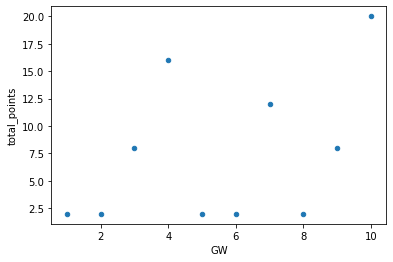

In [7]:
player_GW.loc[player_GW['name'] =='Jamie_Vardy_166'][['GW','total_points']].plot.scatter(x = 'GW', y = 'total_points')

# Point Acquisition Stochastic System (PASS)

## Import data

In [8]:
Season_GW_address = '/Users/calumthompson/Documents/Fantasy football/Fantasy-Premier-League/data/2018-19/gws/merged_gw.csv'
Last_season_totals_address = '/Users/calumthompson/Documents/Fantasy football/Fantasy-Premier-League/data/2017-18/cleaned_players.csv'

### 2018/19 GW data

In [9]:
Season_GW = pd.read_csv(Season_GW_address, encoding='latin-1')

In [10]:
Season_GW['Forename'] = Season_GW['name'].str.split('_', expand=True)[0]
Season_GW['Surname'] = Season_GW['name'].str.split('_', expand=True)[1]

In [11]:
Season_GW = Season_GW.sort_values(['Forename','Surname','GW'])
Season_GW.loc[Season_GW['GW'] > 1,'last_weeks_points'] = Season_GW['total_points'].shift(periods = 1)
Season_GW.loc[Season_GW['GW'] > 2,'last_2weeks_points'] = Season_GW['total_points'].shift(periods = 2)
Season_GW.loc[Season_GW['GW'] > 3,'last_3weeks_points'] = Season_GW['total_points'].shift(periods = 3)
Season_GW.loc[Season_GW['GW'] > 4,'last_4weeks_points'] = Season_GW['total_points'].shift(periods = 4)
Season_GW.loc[Season_GW['GW'] <38,'next_weeks_points'] = Season_GW['total_points'].shift(periods = -1)

### 2017/18 season totals

In [12]:
Last_season_totals = pd.read_csv(Last_season_totals_address, encoding='latin-1')

In [13]:
Last_season_totals = Last_season_totals[['first_name', 'second_name','total_points', 'minutes', 'goals_scored', 'goals_conceded', 'selected_by_percent', 'clean_sheets','red_cards','yellow_cards']]

Last_season_totals.columns = ['Forename','Surname',
                              'last_season_total_points', 'last_season_total_minutes', 
                              'last_season_goals_scored', 'last_season_goals_conceded',
                              'last_season_selected_by_percent', 'last_season_clean_sheets',
                              'last_season_red_cards', 'last_season_yellow_cards']


### Merge

In [14]:
Analysis_df = pd.merge(Season_GW,Last_season_totals, how = 'left', left_on = ['Forename','Surname'], right_on = ['Forename','Surname'])

In [15]:
Analysis_df = Analysis_df.fillna(0)
Analysis_df = Analysis_df.set_index(['GW','Surname','Forename'])

## Sense check

### 2017/18 top point earners

In [16]:
Analysis_df.groupby(['Surname','Forename']).agg({'last_season_total_points': np.mean, 
                                                 'last_season_goals_scored' :np.mean}
                                                ).sort_values('last_season_total_points', ascending = False).head(20)

,,last_season_total_points,last_season_goals_scored
Surname,Forename,,
Salah,Mohamed,303.0,32.0
Sterling,Raheem,229.0,18.0
Kane,Harry,217.0,29.0
De Bruyne,Kevin,209.0,8.0
Eriksen,Christian,199.0,11.0
Mahrez,Riyad,195.0,12.0
Vardy,Jamie,183.0,20.0
Firmino,Roberto,181.0,15.0
Son,Heung-Min,178.0,12.0


### 2018/19 top point earners

In [17]:
Analysis_df.groupby(['Surname','Forename']).agg({'total_points': sum, 
                                                 'goals_scored' :np.mean}
                                                ).sort_values('total_points', ascending = False).head(20)

,,total_points,goals_scored
Surname,Forename,,
Salah,Mohamed,259,0.578947
Hazard,Eden,238,0.421053
Sterling,Raheem,234,0.447368
Mané,Sadio,231,0.578947
Robertson,Andrew,213,0.000000
van Dijk,Virgil,208,0.105263
Aubameyang,Pierre-Emerick,205,0.578947
Agüero,Sergio,201,0.552632
Alexander-Arnold,Trent,185,0.026316


/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


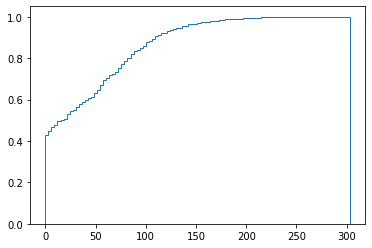

In [18]:
plt.hist(x = Analysis_df['last_season_total_points'], cumulative=True, bins = 100, histtype = 'step', normed = True)
plt.show()

# Model

In [19]:
y = Analysis_df['next_weeks_points']
x = Analysis_df.drop(columns = ['name','next_weeks_points', 'kickoff_time', 'kickoff_time_formatted', 'was_home'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Linear regression

In [20]:
LinR = LinearRegression().fit(x_train, y_train)

In [21]:
r_sq = LinR.score(x_train, y_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.2586362385664447


In [22]:
y_predict = LinR.predict(x_test)

In [23]:
LinRPerformance = pd.DataFrame({'Actual' : y_test, 'Prediction' : y_predict})
LinRPerformance['Delta'] = np.abs(LinRPerformance['Actual'] - LinRPerformance['Prediction'])

In [24]:
print('Average act/pred delta (abs):' , LinRPerformance.Delta.mean())

Average act/pred delta (abs): 1.2599244606909714


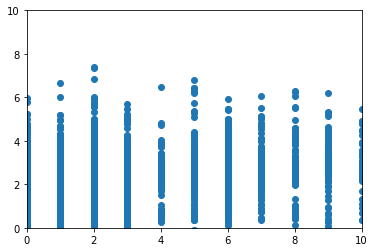

In [25]:
plt.scatter(x = LinRPerformance['Actual'], y = LinRPerformance['Prediction'], label = 'Actual')
plt.xlim(0,10)
plt.ylim(0,10)
plt.show()

## LightGBM

In [49]:
LGB_PARAMS = {
    'learning_rate': 0.063,
    'max_depth': 5,
    'num_leaves': 40, 
    'objective': 'regression',
    'metric':'l2',
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'max_bin': 100,
    'seed':123,}


def crossvalidate_lgb(X_train, y_train, lgb_params, num_boost_round=2000, nfold=5):
    # form LightGBM datasets
    dtrain_lgb = lgb.Dataset(X_train, label=y_train)
    # LightGBM, cross-validation
    cv_result_lgb = lgb.cv(lgb_params, 
                           dtrain_lgb, 
                           num_boost_round=num_boost_round, 
                           nfold=nfold, 
                           stratified=True, 
                           early_stopping_rounds=50, 
                           verbose_eval=10, 
                           show_stdv=True,
                          seed=123,)
    num_boost_rounds_lgb = len(cv_result_lgb['binary_logloss-mean'])
    print(f'num_boost_rounds_lgb={num_boost_rounds_lgb}')
    # train model
    model_cv = lgb.LGBMClassifier(n_estimators=num_boost_rounds_lgb, **lgb_params)
    model_cv.fit(X_train,y_train)
    return cv_result_lgb, model_cv

In [50]:
crossvalidate_lgb (x_train, y_train, lgb_params = LGB_PARAMS)

/Users/calumthompson/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[10]	cv_agg's l2: 5.25224 + 0.234194
[20]	cv_agg's l2: 4.88488 + 0.227323
[30]	cv_agg's l2: 4.77116 + 0.229812
[40]	cv_agg's l2: 4.73319 + 0.227431
[50]	cv_agg's l2: 4.72322 + 0.227497
[60]	cv_agg's l2: 4.71592 + 0.227489
[70]	cv_agg's l2: 4.71443 + 0.224968
[80]	cv_agg's l2: 4.71568 + 0.222256
[90]	cv_agg's l2: 4.71936 + 0.220856
[100]	cv_agg's l2: 4.72497 + 0.222924
[110]	cv_agg's l2: 4.7319 + 0.22426


KeyError: 'binary_logloss-mean'

In [55]:
LGB_PARAMS = {
    'learning_rate': 0.063,
    'max_depth': 5,
    'num_leaves': 40, 
    'objective': 'regression',
    'metric':'l2',
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'max_bin': 100,
    'seed':123}
X_train = x_train,
num_boost_round=2000,
nfold=5
lgb_params = LGB_PARAMS
dtrain_lgb = lgb.Dataset(X_train, label=y_train)

cv_result_lgb = lgb.cv(lgb_params, 
                       dtrain_lgb, 
                       num_boost_round=num_boost_round, 
                       nfold=nfold, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       verbose_eval=10, 
                       show_stdv=True,
                      seed=123)

TypeError: '<=' not supported between instances of 'tuple' and 'int'